In [1]:
import argparse
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import interp1d
import sys
import time
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
import tqdm

In [2]:
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath("__file__"))))
from examples.mlp import mlp
from dist_ir.ir import Topology
from dist_ir.executor import infer_types, Simulator
from dist_ir.executor.cost_model import CostModel
from dist_ir.transforms import filter_transform, mlp_dhp_transform

In [3]:
DEVICE_THROUGHPUT = 6.7e12 # FLOPS
DRAM_BANDWIDTH = 2.7e12 # ???
PCIE_BANDWIDTH = 64 # Gbps
WORLD_SIZE = 2

In [4]:
class Mlp(torch.nn.Module):
    def __init__(self, num_hidden_layers, hidden_dim):
        super().__init__()
        self.blocks = [
            torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
            for _ in range(num_hidden_layers)
        ]
        for i, block in enumerate(self.blocks):
            for j, param in enumerate(block.parameters()):
                if j > 0:
                    raise ValueError(f"Block {i} has more than 1 parameter!")
                self.register_parameter(f"w{chr(ord('A')+i)}", param)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
            relu = torch.nn.ReLU()
            x = relu(x)
        return x

In [5]:
def setup(
    local_rank, world_size, backend="nccl", master_addr="localhost", master_port="12355"
):
    os.environ["MASTER_ADDR"] = master_addr
    os.environ["MASTER_PORT"] = master_port
    torch.distributed.init_process_group(
        backend, world_size=world_size, rank=local_rank
    )

In [6]:
def cleanup():
    torch.distributed.destroy_process_group()

In [7]:
def run(config):
    (
        local_rank,
        world_size,
        num_hidden_layers,
        batch_size,
        hidden_dim,
        num_warmup_steps,
        num_profiling_steps,
    ) = config
    model = Mlp(num_hidden_layers, hidden_dim).to(local_rank)
    loss_fn = torch.nn.MSELoss()
    x = torch.randn(size=(batch_size // world_size, hidden_dim)).to(local_rank)
    labels = torch.randn(size=(batch_size // world_size, hidden_dim)).to(local_rank)
    setup(local_rank, world_size)
    model = DDP(model, device_ids=[local_rank], output_device=local_rank)
    runtimes = []
    for i in range(num_warmup_steps + num_profiling_steps):
        start = time.time()
        y = model(x)
        loss_fn(y, labels).backward()
        duration = time.time() - start
        runtimes.append(duration)
    cleanup()
    return np.median(runtimes[num_warmup_steps:])

In [8]:
def distributed_driver(num_hidden_layers, batch_size, hidden_dim, world_size):
    configs = [
        (rank, world_size, num_hidden_layers, batch_size, hidden_dim, 10, 100)
        for rank in range(world_size)
    ]
    with torch.multiprocessing.Pool(world_size) as p:
        results = p.map(run, configs)
    print(
        f"num_hidden_layers={num_hidden_layers}, "
        f"batch_size={batch_size}, "
        f"hidden_dim={hidden_dim}, "
        f"runtime={np.mean(results)}"
    )
    return np.mean(results)

In [9]:
def simulate(num_hidden_layers, batch_size, hidden_dim, world_size):
    topology = Topology()
    d0 = topology.add_device(
        "gpu", throughput=DEVICE_THROUGHPUT, dram_bandwidth=DRAM_BANDWIDTH
    )
    for i in range(world_size):
        di = topology.add_device(
            "gpu", throughput=DEVICE_THROUGHPUT, dram_bandwidth=DRAM_BANDWIDTH
        )
        topology.set_bandwidth(d0, di, float("inf"))
        for j in range(1, i + 1):
            dj = topology.devices[j]
            topology.set_bandwidth(di, dj, PCIE_BANDWIDTH)
    function = mlp(
        batch_size, hidden_dim, hidden_dim, hidden_dim, num_hidden_layers, d0
    )
    function = infer_types(function, function.inputs)
    dp_function = mlp_dhp_transform(function, world_size, 1, 1, topology.devices, 1)
    dp_function = infer_types(dp_function, dp_function.inputs)
    # dp_function = filter_transform(dp_function)
    simulator = Simulator(CostModel(topology))
    simulation = simulator.interpret(
        dp_function,
        (v.type for v in dp_function.inputs),
    )
    return max([simulation.timestamps[d] for d in simulation.timestamps])

In [10]:
def parse_csv(filename):
    results = []
    with open(filename, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            results.append(
                (
                    row["num_hidden_layers"],
                    row["batch_size"],
                    row["hidden_dim"],
                    row["runtime"],
                )
            )
    return results

In [11]:
def sweep(
    all_num_hidden_layers, all_batch_sizes, all_hidden_dims, world_size, filename, func
):
    fieldnames = ["num_hidden_layers", "batch_size", "hidden_dim", "runtime"]
    with open(filename, "w") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for num_hidden_layers in all_num_hidden_layers:
            for batch_size in all_batch_sizes:
                for hidden_dim in all_hidden_dims:
                    runtime = func(
                        num_hidden_layers, batch_size, hidden_dim, world_size
                    )
                    writer.writerow(
                        {
                            "num_hidden_layers": num_hidden_layers,
                            "batch_size": batch_size,
                            "hidden_dim": hidden_dim,
                            "runtime": runtime,
                        }
                    )

In [12]:
all_num_hidden_layers = [8, 16, 32]
all_batch_sizes = [512, 1024, 2048]
all_hidden_dims = [1024, 2048, 4096]
# sweep(
#     all_num_hidden_layers,
#     all_batch_sizes,
#     all_hidden_dims,
#     WORLD_SIZE,
#     "data_parallel_runtimes.csv",
#     distributed_driver,
# )
sweep(
    all_num_hidden_layers,
    all_batch_sizes,
    all_hidden_dims,
    WORLD_SIZE,
    "data_parallel_simulated_runtimes.csv",
    simulate,
)

In [13]:
real_results = parse_csv("data_parallel_runtimes.csv")
simulated_results = parse_csv("data_parallel_simulated_runtimes.csv")

In [14]:
real_throughputs = []
simulated_throughputs = []
model_sizes = []
print(f"# layers,batch size,hidden dim,model size (MB),real,simulated,ratio")
for real, simulated in zip(real_results, simulated_results):
    num_hidden_layers = int(real[0])
    batch_size = int(real[1])
    hidden_dim = int(real[2])
    real_runtime = float(real[3])
    simulated_runtime = float(simulated[-1])
    model_size = hidden_dim * hidden_dim * num_hidden_layers * 4 / (1024 * 1024)
    print(
        f"{num_hidden_layers},{batch_size},{hidden_dim},"
        f"{model_size},{real_runtime*1000:.2f},"
        f"{simulated_runtime*1000:.2f},"
        f"{(simulated_runtime/real_runtime):.2f}x"
    )
    real_throughputs.append(batch_size / real_runtime / 1000)
    simulated_throughputs.append(batch_size / simulated_runtime / 1000)
    model_sizes.append(model_size)

# layers,batch size,hidden dim,model size (MB),real,simulated,ratio
8,512,1024,32.0,11.26,7.19,0.64x
8,512,2048,128.0,40.19,26.63,0.66x
8,512,4096,512.0,160.79,102.31,0.64x
8,1024,1024,32.0,12.75,10.17,0.80x
8,1024,2048,128.0,43.34,36.44,0.84x
8,1024,4096,512.0,170.22,137.31,0.81x
8,2048,1024,32.0,15.22,16.13,1.06x
8,2048,2048,128.0,49.28,56.06,1.14x
8,2048,4096,512.0,188.45,207.31,1.10x
16,512,1024,64.0,21.22,13.33,0.63x
16,512,2048,256.0,79.61,51.17,0.64x
16,512,4096,1024.0,318.38,200.42,0.63x
16,1024,1024,64.0,23.72,18.24,0.77x
16,1024,2048,256.0,85.01,68.69,0.81x
16,1024,4096,1024.0,337.58,266.23,0.79x
16,2048,1024,64.0,27.33,28.06,1.03x
16,2048,2048,256.0,97.27,103.72,1.07x
16,2048,4096,1024.0,381.85,397.84,1.04x
32,512,1024,128.0,41.53,25.60,0.62x
32,512,2048,512.0,158.31,100.25,0.63x
32,512,4096,2048.0,635.24,396.65,0.62x
32,1024,1024,128.0,45.74,34.38,0.75x
32,1024,2048,512.0,168.58,133.18,0.79x
32,1024,4096,2048.0,674.00,524.06,0.78x
32,2048,1024,128.0,51.53,51.93,1.01x
32,204

Pearson's correlation: 0.9739922409909063


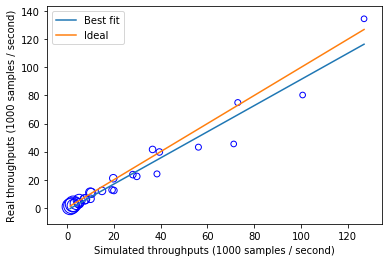

In [16]:
simulated_throughputs = np.array(simulated_throughputs)
real_throughputs = np.array(real_throughputs)
r = np.corrcoef(simulated_throughputs, real_throughputs)[0,1]
print("Pearson's correlation:", r)
m, b = np.polyfit(simulated_throughputs, real_throughputs, 1)
x_new = np.linspace(simulated_throughputs.min(), simulated_throughputs.max(), 500)
f = interp1d(simulated_throughputs, m * simulated_throughputs + b, kind="linear")
y_smooth = f(x_new)
plt.plot(x_new, y_smooth, label="Best fit")
plt.plot(x_new, x_new, label="Ideal")
colors=["b", "orange", "g", "purple"]
scaled_model_sizes = np.array(model_sizes, dtype=np.float32)
scaled_model_sizes -= np.min(model_sizes)
scaled_model_sizes *= 1.0 / (np.max(model_sizes) - np.min(model_sizes))
scaled_model_sizes *= 224
scaled_model_sizes += 32
plt.scatter(
    simulated_throughputs,
    real_throughputs,
    s=scaled_model_sizes,
    facecolors="none",
    edgecolors="b",
)
plt.xlabel("Simulated throughputs (1000 samples / second)")
plt.ylabel("Real throughputs (1000 samples / second)")
plt.legend()
plt.savefig("data_parallel_simulation_performance.pdf", dpi=600, bbox_inches="tight")